# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

<font color="blue"> **Comment:** Hi! I didn't manage to finish everything in this lab :( However, please check all sections, since I might have some things missing in between but answers there below.

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [208]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self):
        return self
    
    def tanh(self):
        return Var(tanh(self.v), [(self, 1 - tanh(self.v) ** 2)])
    
    def sigmoid(self):
        return Var((1 + exp(-1.0 * self.v)) ** -1, [self, (1 + exp(-1.0 * self.v)) ** -1 * (1 - (1 + exp(-1.0 * self.v)) ** -1)])

A few examples illustrate how we can use this:

In [264]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [265]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

<font color = "blue"> **Solution:** </font> The output of the code shows us the value of each variable, `v`, as well as the value of the gradient of that variable, `grad`. The expression that we differentiate is `f` or the variable on which we call `.backward()`. We build the function `f` with each variable, forward from inputs to output, and then work our way backwards and differentiate `f` with regards to each variable it consists of (including itself).

<font color="red"> **Answer from peergrade submission 1:** Each operation done on a Var instance creates a new Var instance with a non-empty list grad_fn. This list contains tuples of (input, grad) pairs, where each affected input is stored along with the derivative modifier that corresponds to the operation. When the backward() method is called, the backprop() method is activated, which recursively computes and changes the Var.grad for the input instances in each tuple in the grad_fn list.

## Exercise b) How does the backward function work?

For the first example above, execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above. 

<font color = "blue"> **Solution:** </font> The first example above is set up like this:
```
a = Var(3.0)
b = Var(5.0)
f = a * b
f.backward()
```
Walking through the procedure:
* First, we initiate `a`. 
* Next we initiate `b`. 
* Then we multiply those two variables. 
* After that, we can initiate `f`. Our whole function is ready.
* Then, we call `f.backward()`.
    * Backpropagation 1: Differentiate `f` w.r.t. `f`. `grad = 1.0`.
    * Backpropagation 2: Differentiate `f` w.r.t. `b`. `grad = 3.0` as a result of the `__mul__` function.
    * Backpropagation 3: Differentiate `f` w.r.t. `a`. `grad = 5.0` as a result of the `__mul__` function.

Mathematical differentations:

* Differentation with regards to $f$, which gives us `Var(v=15.0000, grad=1.0000)`:

$$
\begin{align}
\texttt{v} &= f = a \cdot b = 3 \cdot 5 = 15 \\
\texttt{grad} &= \frac{\partial f}{\partial f} = 1
\end{align}
$$

* Differentation with regards to $b$, which gives us `Var(v=5.0000, grad=3.0000)`:

$$
\begin{align}
\texttt{v} &= b = 5 \\
\texttt{grad} &= \frac{\partial f}{\partial b} = \frac{\partial}{\partial b} (a \cdot b) = a = 3
\end{align}
$$

* Differentation with regards to $a$, which gives us `Var(v=3.0000, grad=5.0000)`:

$$
\begin{align}
\texttt{v} &= a = 3 \\
\texttt{grad} &= \frac{\partial f}{\partial a} = \frac{\partial}{\partial a} (a \cdot b) = b = 5
\end{align}
$$

<font color="red"> **Answer from peergrade submission 1:**

In [ ]:
a = Var(3.0) # variable a with value=3 and grad=0 is defined
b = Var(5.0) # variable b with value=5 and grad=0 is defined
f = a * b
# variable f is a new instance of Var with value: Var.v = a.v * b.v = 3 * 5 = 15 and grad=0
# Meanwhile, the operation is saved in f.grad_fn as 2 tuples, one where a is input and the grad value is b.v
# and one where b is input and the grad value is a.v
# The grad value is the value of the instance that is not the input, since df/da=b.v, and df/db=a.v, for this operation

f.backward()
# The backward() method calls the backprop() method with an input parameter bp of 1.0
# The backprop() method increments Var.grad with the input parameter bp,
# and then loops through the grad_fn list, recursively calling backprop() on each input
# and giving the saved grad value multiplied with bp and the new bp
# This way, all numeric values of partial derivatives are efficiently calculated
# The formal descriptions of the partial derivatives are lost (which doesn't matter)
# and only the actual numerical values is stored so everything is computed quickly.

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [266]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


<font color = "blue"> **Solution:** </font> *The gradient value doubles for each variable.* When we first run `f.backward()`, we run `self.backprop(1.0)`, i.e. with `bp = 1.0`. The gradient then (for `f`) becomes `grad = 0.0 + 1.0 = 1.0` and so on, with each variable initiated with `grad = 0.0`. When we run `backward()` again, the first run where we calculate the gradient of `f` results in `grad = 2.0`, because  `grad = 1.0` from the previous run and `bp = 1.0` again. This, as well as the other calculated variables `c` and `e` having now `grad = 2.0`, results in the base variables `a`, `b` and `d` having double their previous gradient values.

This can also be seen if we try to run it again and again - the gradients for `f`, `c` and `e` always increase by one and the other gradients are then multiplied by the ever increasing values of those gradients.

<font color="red"> **Answer from peergrade submission 1:** Before the function call, we have f.v=42, f.grad = 1

f.backward() calls f.backprop(1.0) which first increments f.grad with 1

f.grad_fn is a list of 2 tuples:
tuple 1: (c, 1.0)
tuple 2: (e, 1.0)
The 1.0 values are from the addition method.

For each tuple (in_1,bp_1) in f.grad_fn, the backprop() method is called:
in_1.backprop(bp_1*bp) meaning backprop is called on both c and e with 1.0*1.0=1.0 as input parameter.

This recursively activates grad_fn of c and e, which both have multiplication as their origin, and therefore each have 2 tuples with the general form of:
tuple 1: (var1, var2.v)
tuple 2: (var2, var1.v)

Meaning var1 and var2 will both have their backprop() method activated for both c and e, and they will all have an input parameter of 1.0*varOther.v

a is present in both calculations of c and e, so it's backprop method is called 2 times, meaning its .grad attribute is modified  both by b.v (in the computation of c), and by d.v (in the computation of e).


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going.

In [268]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=0.0000)
Var(v=15.0000, grad=0.0000)
Var(v=9.0000, grad=0.0000)
Var(v=27.0000, grad=0.0000)
Var(v=42.0000, grad=0.0000)


<font color = "blue"> **Solution:** </font> .........

<font color="red"> **Answer from peergrade submission 1:** The increment on the original Var activating backprop() goes back by -1, and all following recursive activations receive a negative input as long as the .grad attribute has a positive value since they are multiplied in the input of the recursive activation.

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.


_Insert your code in the cell below._

<font color = "blue"> **Solution:** </font>

In [213]:
# Test function - try to change into other functions as well
def test_function(a):
    a = Var(a)
    b = Var(5.0)
    f = a * b
    f.backward()
    return a,b,f

a = 12.0

for v in test_function(a):
    print(v)

# Insert your finite difference code here
def finite_difference(a, da = 1e-10):
    """
    This function computes the finite difference.
    
    Input:
    a:           The point for which we want to approx the derivative (float)
    da:          The finite difference                                (float)
    
    Output:
    finite_difference: numerical approximation to the derivative      (float) 
    """

    fa_da = test_function(a + da)[-1].v      # <- Insert correct expression - INSERTED
    fa = test_function(a)[-1].v              # <- Insert correct expression - INSERTED

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference(a))

Var(v=12.0000, grad=5.0000)
Var(v=5.0000, grad=12.0000)
Var(v=60.0000, grad=1.0000)
5.000018177270249


We can see that the finite difference method gives results very close to the actual result.

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [214]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [215]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [216]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

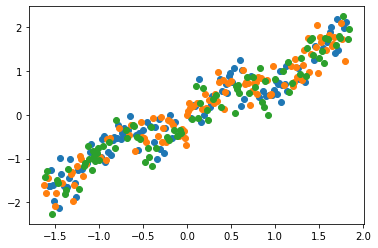

In [217]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [218]:
# convert from nparray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)

# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [219]:
class Initializer:
    
    def init_weights(self, n_in, n_out):
        raise NotImplementedError

    def init_bias(self, n_out):
        raise NotImplementedError

In [220]:
import random

class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(self.bias) for _ in range(n_out)]

In [233]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + '\nBiases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
        params = []
        for r in self.weights:
            params += r

        return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"
        weights = self.weights
        out = []
        for j in range(len(weights[0])):
            node = self.bias[j]                    # <- Insert code - INSERTED
            for i in range(len(inputs)):
                node += weights[i][j] * inputs[i]  # <- Insert code - INSERTED
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. The forward method in DenseLayer is not complete. It  just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [238]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

    def forward_single(x, network):
        for layer in network:
            x = layer.forward(x)
        return x

    # PROBABLY SHOULDN'T HAVE EINSUM HERE BELOW
    output = [forward_single(np.einsum('n', input[n]), network) for n in range(len(input))]
    return output

print(forward(x_train, NN))

[[Var(v=0.0067, grad=0.0000)], [Var(v=0.0135, grad=0.0000)], [Var(v=0.0012, grad=0.0000)], [Var(v=0.0342, grad=0.0000)], [Var(v=0.0099, grad=0.0000)], [Var(v=0.0092, grad=0.0000)], [Var(v=0.0060, grad=0.0000)], [Var(v=0.0082, grad=0.0000)], [Var(v=0.0352, grad=0.0000)], [Var(v=0.0037, grad=0.0000)], [Var(v=0.0104, grad=0.0000)], [Var(v=0.0217, grad=0.0000)], [Var(v=0.0083, grad=0.0000)], [Var(v=0.0248, grad=0.0000)], [Var(v=0.0045, grad=0.0000)], [Var(v=0.0087, grad=0.0000)], [Var(v=0.0160, grad=0.0000)], [Var(v=0.0076, grad=0.0000)], [Var(v=0.0008, grad=0.0000)], [Var(v=0.0026, grad=0.0000)], [Var(v=0.0163, grad=0.0000)], [Var(v=0.0072, grad=0.0000)], [Var(v=0.0117, grad=0.0000)], [Var(v=0.0118, grad=0.0000)], [Var(v=0.0095, grad=0.0000)], [Var(v=0.0256, grad=0.0000)], [Var(v=0.0151, grad=0.0000)], [Var(v=0.0166, grad=0.0000)], [Var(v=0.0018, grad=0.0000)], [Var(v=0.0105, grad=0.0000)], [Var(v=0.0321, grad=0.0000)], [Var(v=0.0025, grad=0.0000)], [Var(v=0.0280, grad=0.0000)], [Var(v=0.

## Exercise g) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [239]:
# Insert code here and in the DenseLayer class
def printLayerParameters(network):
    count = 0
    for layer in network:
        print(f'--- Layer {count} ---')
        print(layer)
        count +=1

printLayerParameters(NN)

--- Layer 0 ---
Weights: [[Var(v=-0.0356, grad=0.0000), Var(v=0.1345, grad=0.0000), Var(v=-0.1478, grad=0.0000), Var(v=0.1943, grad=0.0000), Var(v=0.0012, grad=0.0000)]]
Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
--- Layer 1 ---
Weights: [[Var(v=-0.2323, grad=0.0000)], [Var(v=0.0236, grad=0.0000)], [Var(v=0.2080, grad=0.0000)], [Var(v=0.0320, grad=0.0000)], [Var(v=-0.0572, grad=0.0000)]]
Biases: [Var(v=0.0000, grad=0.0000)]


# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 

## Exercise h) Add more activation functions

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

<font color = "blue"> **Solution:** </font> Inserted in `class Var` at the top:
```
def identity(self):
    return self
        
def tanh(self):
        return Var(tanh(self.v), [(self, 1 - tanh(self.v) ** 2)])
    
def sigmoid(self):
    return Var((1 + exp(-1.0 * self.v)) ** -1, [self, (1 + exp(-1.0 * self.v)) ** -1 * (1 - (1 + exp(-1.0 * self.v)) ** -1)])
```

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

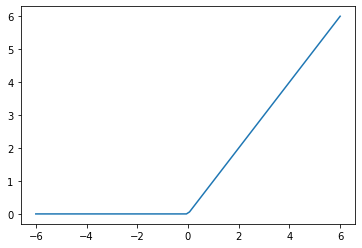

In [241]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
    y = np.zeros((len(x),len(x[0])))
    for i in range(len(x)):
        for j in range(len(x[0])):
            y[i,j] = x[i][j].v
    return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

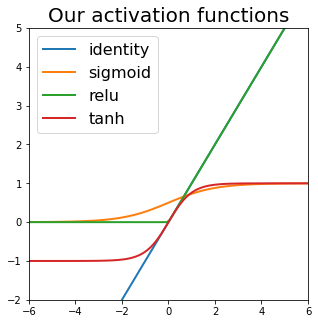

In [242]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),  # <- uncomment before sharing
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh() # <- uncomment before sharing
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

<font color = "blue"> **Solution:** </font>

In [175]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    alpha = 1
    std = 2 * alpha / (n_in + n_out) # <- replace with proper initialization - REPLACED
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
    alpha = 2
    std = alpha / n_in # <- replace with proper initialization - REPLACED
    return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

<font color="red"> **Answer from peergrade submission 3:** ERROR IN MINE!! The equations above give VARIANCE and we're supposed to calculate STANDARD DEVIATION = SQRT(VARIANCE) in the functions above. Code from submission 3:

In [ ]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  std = sqrt(2 / (n_in + n_out))
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = sqrt(2 / n_in)
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

def DenseLayer_Universal(n_in: int, n_out: int, activation_function: str, initializer_type: str):
  assert activation_function in ["tanh", "ReLU"]
  assert initializer_type in ["He", "Glorot"]
  alpha = 1 if activation_function == "tanh" else 2
  std = sqrt(2 * alpha / (n_in + n_out)) if initializer_type == "Glorot" else sqrt(alpha / n_in)
  activation = lambda x: x.tanh() if activation_function == "tanh" else lambda x: x.relu()
  return DenseLayer(n_in, n_out, activation, initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

<font color="red"> **Answer from peergrade submission 2:**

In [282]:
# Insert code here
NN_test = [
  DenseLayer(10, 1, lambda x: x.identity(), initializer = ConstantInitializer(1.0, 0.0))
]

PrintParam(NN_test)

x = np.array([np.linspace(x*10+1, x*10+10, 10) for x in range(10)])
y = Var_to_nparray(forward(nparray_to_Var(x), NN_test))

print(x,y,sep="\n")

assert np.all(y.T[0] == np.sum(x, axis=1)), "The outputs do not match"

<font color="red"> **Answer from peergrade submission 3:**

In [ ]:
# Insert code here
input = np.linspace(-10, 10, 100)
NN = [
    DenseLayer(1, 1, lambda x: x.identity(), initializer = ConstantInitializer())
]
output = Var_to_nparray(forward(nparray_to_Var(x), NN))
assert input.all() == output.all()

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [245]:
def squared_loss(t, y):
  
  # add check that sizes agree
    def squared_loss_single(t, y):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += (t[i]-y[i]) ** 2
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += squared_loss_single(t[n],y[n])
    return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'} } .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [246]:
def cross_entropy_loss(t, y):
     
    Loss = Var(0.0)
    # Insert code here
    return Loss

<font color="red"> **Answer from peergrade submission 2:**

In [ ]:
def cross_entropy_loss_single(t, y):
        Loss = Var(0.0)
        SumExp = Var(0.0)
        for i in range(len(y)):
            Loss -= t[i] * y[i]
            SumExp += y[i].exp()
        Loss += SumExp.log()
        return Loss

def cross_entropy_loss(t, y):
    Loss = Var(0.0)

    for n in range(len(t)): # sum over training data
        Loss += cross_entropy_loss_single(t[n],y[n])
    
    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [247]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [248]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.1329, grad=-0.8185), Var(v=0.0171, grad=12.2873), Var(v=-0.0186, grad=-3.8901), Var(v=0.0725, grad=7.0822), Var(v=-0.0207, grad=-5.2937)]]
Biases: [Var(v=0.0000, grad=0.7440), Var(v=0.0000, grad=10.5533), Var(v=0.0000, grad=3.5361), Var(v=0.0000, grad=6.0828), Var(v=0.0000, grad=4.8120)]
Layer 1 
 Weights: [[Var(v=0.0085, grad=12.8029)], [Var(v=-0.1200, grad=-1.7507)], [Var(v=0.0404, grad=1.7892)], [Var(v=-0.0692, grad=-7.4198)], [Var(v=0.0550, grad=1.9920)]]
Biases: [Var(v=0.0000, grad=-0.3751)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [249]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [250]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
    params = []
    for layer in range(len(network)):
        params += network[layer].parameters()
    return params

def update_parameters(params, learning_rate=0.01):
    for p in params:
        p.v -= learning_rate*p.grad

def zero_gradients(params):
    for p in params:
        p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0630, grad=-23.4848), Var(v=0.0224, grad=13.9708), Var(v=-0.1459, grad=-1.0529), Var(v=-0.0785, grad=-18.7822), Var(v=-0.1392, grad=-0.6380)]]
Biases: [Var(v=0.0000, grad=-20.1783), Var(v=0.0000, grad=12.0038), Var(v=0.0000, grad=0.9573), Var(v=0.0000, grad=17.0775), Var(v=0.0000, grad=0.5801)]
Layer 1 
 Weights: [[Var(v=0.2341, grad=-6.3237)], [Var(v=-0.1393, grad=-2.2492)], [Var(v=0.0108, grad=14.2631)], [Var(v=0.1921, grad=7.6724)], [Var(v=0.0065, grad=13.6122)]]
Biases: [Var(v=0.0000, grad=2.7034)]

Network after update:
Layer 0 
 Weights: [[Var(v=0.2979, grad=-23.4848), Var(v=-0.1173, grad=13.9708), Var(v=-0.1354, grad=-1.0529), Var(v=0.1093, grad=-18.7822), Var(v=-0.1329, grad=-0.6380)]]
Biases: [Var(v=0.2018, grad=-20.1783), Var(v=-0.1200, grad=12.0038), Var(v=-0.0096, grad=0.9573), Var(v=-0.1708, grad=17.0775), Var(v=-0.0058, grad=0.5801)]
Layer 1 
 Weights: [[Var(v=0.2973, grad=-6.3237)], [Var(v=-0.1168, grad=-2.2492)], [Var(

[None, None]

In [ ]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [ ]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [ ]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 104.544 	 Validation loss: 105.001
  10 ( 5.00%) Train loss: 36.583 	 Validation loss: 34.438
  20 (10.00%) Train loss: 16.135 	 Validation loss: 14.132
  30 (15.00%) Train loss: 14.970 	 Validation loss: 12.217
  40 (20.00%) Train loss: 14.365 	 Validation loss: 11.332
  50 (25.00%) Train loss: 13.856 	 Validation loss: 10.711
  60 (30.00%) Train loss: 13.387 	 Validation loss: 10.282
  70 (35.00%) Train loss: 13.011 	 Validation loss: 9.923
  80 (40.00%) Train loss: 12.723 	 Validation loss: 9.639
  90 (45.00%) Train loss: 12.446 	 Validation loss: 9.425
 100 (50.00%) Train loss: 12.246 	 Validation loss: 9.233
 110 (55.00%) Train loss: 12.107 	 Validation loss: 9.098
 120 (60.00%) Train loss: 12.029 	 Validation loss: 9.015
 130 (65.00%) Train loss: 11.983 	 Validation loss: 8.969
 140 (70.00%) Train loss: 11.954 	 Validation loss: 8.953
 150 (75.00%) Train loss: 11.933 	 Validation loss: 8.947
 160 (80.00%) Train loss: 11.919 	 Validation loss: 8.944
 170 

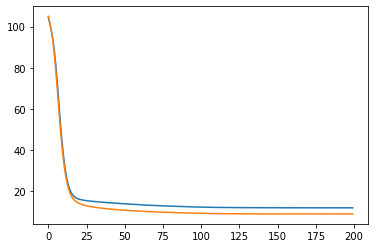

In [ ]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [ ]:
output_test = forward(x_test, NN)

Test loss:  9.798


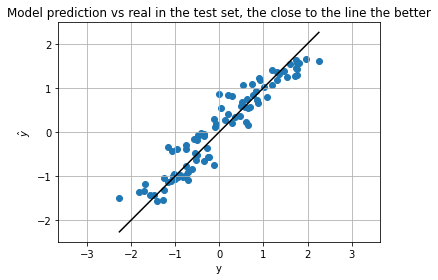

In [ ]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

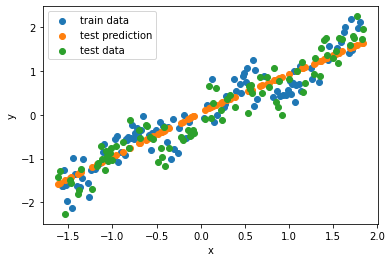

In [ ]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of **overfitting (=training loss significantly lower than test loss)** and **underfitting (=not fitting enoung to training data so that test performance is also hurt)**.

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._

In [ ]:
# Insert your code for getting overfitting, underfitting and just right fitting

<font color="red"> **Answer and code from peergrade submission 2:**
    
To combat the over and underfitting, some checks can be implemented to terminate the training in each case. For example, if the training loss becomes significantly lower than the test loss, the training could be terminated to prevent further overfitting. Both these methods have been implemented in the code.

I did not observe a big difference in validation and test loss in this case.

It is important to keep these seperated, as it is still possible to introduce overfitting, by training on several hyperparameters and finally finding something that gives a low test-error. In this way you have actually ended up also fitting to the test data by trying several hyperparameters. Therefore a validation set should always be used to give the final evaluation of the model.

In [ ]:
# Insert your code for getting overfitting, underfitting and just right fitting
# Overfitting check
    if len(val_loss) > 5 and val_loss[-1] < Loss_validation.v:
        print("Overfitting: Terminated")
        val_loss.append(Loss_validation.v)
        break

# Underfitting check
    if len(train_loss) > 5 and train_loss[-1] < Loss.v:
        print("Underfitting: Terminated")
        train_loss.append(Loss.v)
        break

<font color="red"> **Answer and code from peergrade submission 2:** The validation loss is there to give a breaf overview of the network's performance after each iteration of refining the neural network. This is useful because by utilizing these losses we can compare the models' perfomance and tune the hyperparameters to get the best possible model (before finalizing the model). By modifying the hyperparameters using the validation losses to get a better performing NN, the accuracy is no longer unbiased regarding the validation loss. Because of this, we need a dataset to check the unbiased accuracy of the final, trained network. The test loss is to give an unbiased estimate of the final, trained model's performance.

In [ ]:
def fit_model(epochs, learning_rate, neural_network, y_train_data, x_train_data, y_validation_data, x_validation_data, y_test_data, x_test_data):
    train_loss = []
    val_loss = []

    for e in range(epochs):
      
        # Forward pass and loss computation
        Loss = squared_loss(y_train_data, forward(x_train_data, neural_network))

        # Backward pass
        Loss.backward()

        # gradient descent update
        update_parameters(parameters(neural_network), learning_rate)
        zero_gradients(parameters(neural_network))

        # Training loss
        train_loss.append(Loss.v)

        # Validation
        Loss_validation = squared_loss(y_validation_data, forward(x_validation_data, neural_network))
        val_loss.append(Loss_validation.v)

        if e%10==0:
            print("{:4d}".format(e),
                "({:5.2f}%)".format(e/epochs*100), 
                "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

        plt.plot(range(len(train_loss)), train_loss);
        plt.plot(range(len(val_loss)), val_loss);
        plt.show()

        Loss_test = squared_loss(y_test_data, forward(x_test_data, neural_network))
        print("Test loss:  {:4.3f}".format(Loss_test.v))

        output_test = forward(x_test_data, neural_network)
        y_test_np = Var_to_nparray(y_test_data)
        x_test_np = Var_to_nparray(x_test_data)
        x_train_np = Var_to_nparray(x_train_data)
        y_train_np = Var_to_nparray(y_train_data)

        if D1:
            plt.scatter(x_train_np, y_train_np, label="train data");
            plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
            plt.scatter(x_test_np, y_test_np, label="test data");
            plt.legend();
            plt.xlabel("x");
            plt.ylabel("y");
        else:
            plt.scatter(x_train_np[:,1], y_train_data, label="train data");
            plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
            plt.scatter(x_test_np[:,1], y_test_np, label="test data");
            plt.legend();
            plt.xlabel("x");
            plt.ylabel("y");

Overfitting can be caused by insufficient training data, too complex NN, and even overtraining (if the NN was able to 'learn' the general features but we run even more epochs, 
it can 'fixate' on the training data rather than a general overview and basically memorize the inputs)

   0 ( 0.00%) Train loss: 9.722 	 Validation loss: 4.622
  10 ( 0.25%) Train loss: 9.642 	 Validation loss: 4.562
  20 ( 0.50%) Train loss: 9.562 	 Validation loss: 4.503
  30 ( 0.75%) Train loss: 9.482 	 Validation loss: 4.446
  40 ( 1.00%) Train loss: 9.401 	 Validation loss: 4.389
  50 ( 1.25%) Train loss: 9.321 	 Validation loss: 4.333
  60 ( 1.50%) Train loss: 9.239 	 Validation loss: 4.278
  70 ( 1.75%) Train loss: 9.158 	 Validation loss: 4.223
  80 ( 2.00%) Train loss: 9.076 	 Validation loss: 4.168
  90 ( 2.25%) Train loss: 8.993 	 Validation loss: 4.113
 100 ( 2.50%) Train loss: 8.911 	 Validation loss: 4.059
 110 ( 2.75%) Train loss: 8.827 	 Validation loss: 4.005
 120 ( 3.00%) Train loss: 8.742 	 V

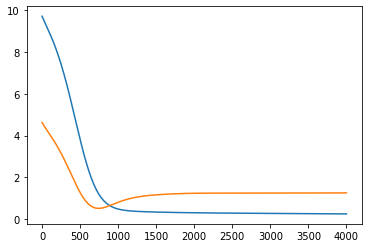

Test loss:  1.044


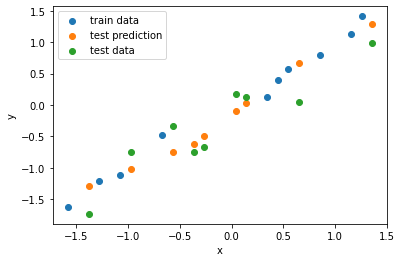

In [ ]:
# Insert your code for getting overfitting, underfitting and just right fitting
print("Overfitting can be caused by insufficient training data, too complex NN, and even overtraining (if the NN was able to 'learn' the general features but we run even more epochs, \nit can 'fixate' on the training data rather than a general overview and basically memorize the inputs)\n")
x_train_over, y_train_over,  x_validation_over, y_validation_over, x_test_over, y_test_over = data_generator(noise=0.5, n_samples=30, D1=D1)
x_train_over = nparray_to_Var(x_train_over)
y_train_over = nparray_to_Var(y_train_over)
x_validation_over = nparray_to_Var(x_validation_over)
y_validation_over = nparray_to_Var(y_validation_over)
x_test_over = nparray_to_Var(x_test_over)
y_test_over = nparray_to_Var(y_test_over)

NN_over = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

fit_model(4000, 2e-4, NN_over, y_train_over, x_train_over, y_validation_over, x_validation_over, y_test_over, x_test_over)

   0 ( 0.00%) Train loss: 79.428 	 Validation loss: 70.667
  10 ( 5.00%) Train loss: 45.770 	 Validation loss: 43.913
  20 (10.00%) Train loss: 33.793 	 Validation loss: 34.043
  30 (15.00%) Train loss: 28.260 	 Validation loss: 29.388
  40 (20.00%) Train loss: 25.194 	 Validation loss: 26.793
  50 (25.00%) Train loss: 23.287 	 Validation loss: 25.182
  60 (30.00%) Train loss: 22.005 	 Validation loss: 24.108
  70 (35.00%) Train loss: 21.093 	 Validation loss: 23.353
  80 (40.00%) Train loss: 20.418 	 Validation loss: 22.801
  90 (45.00%) Train loss: 19.902 	 Validation loss: 22.386
 100 (50.00%) Train loss: 19.497 	 Validation loss: 22.067
 110 (55.00%) Train loss: 19.173 	 Validation loss: 21.816
 120 (60.00%) Train loss: 18.909 	 Validation loss: 21.617
 130 (65.00%) Train loss: 18.691 	 Validation loss: 21.456
 140 (70.00%) Train loss: 18.508 	 Validation loss: 21.324
 150 (75.00%) Train loss: 18.354 	 Validation loss: 21.216
 160 (80.00%) Train loss: 18.223 	 Validation loss: 21.1

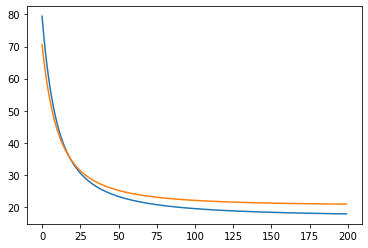

Test loss:  16.853


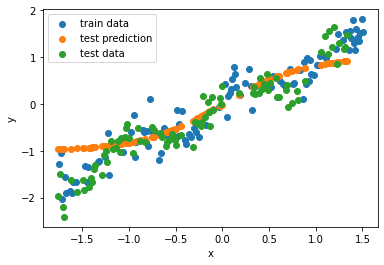

In [ ]:
x_train_under, y_train_under,  x_validation_under, y_validation_under, x_test_under, y_test_under = data_generator(noise=0.5, n_samples=300, D1=D1)
x_train_under = nparray_to_Var(x_train_under)
y_train_under = nparray_to_Var(y_train_under)
x_validation_under = nparray_to_Var(x_validation_under)
y_validation_under = nparray_to_Var(y_validation_under)
x_test_under = nparray_to_Var(x_test_under)
y_test_under = nparray_to_Var(y_test_under)

NN_under = [
    DenseLayer(1, 1, lambda x: x.tanh()),
]

fit_model(200, 2e-4, NN_under, y_train_under, x_train_under, y_validation_under, x_validation_under, y_test_under, x_test_under)

   0 ( 0.00%) Train loss: 155.383 	 Validation loss: 145.854
  10 ( 0.50%) Train loss: 87.013 	 Validation loss: 91.618
  20 ( 1.00%) Train loss: 44.243 	 Validation loss: 45.277
  30 ( 1.50%) Train loss: 15.614 	 Validation loss: 16.139
  40 ( 2.00%) Train loss: 13.087 	 Validation loss: 12.707
  50 ( 2.50%) Train loss: 12.238 	 Validation loss: 11.595
  60 ( 3.00%) Train loss: 11.640 	 Validation loss: 10.872
  70 ( 3.50%) Train loss: 11.236 	 Validation loss: 10.388
  80 ( 4.00%) Train loss: 10.976 	 Validation loss: 10.075
  90 ( 4.50%) Train loss: 10.815 	 Validation loss: 9.876
 100 ( 5.00%) Train loss: 10.718 	 Validation loss: 9.752
 110 ( 5.50%) Train loss: 10.661 	 Validation loss: 9.675
 120 ( 6.00%) Train loss: 10.628 	 Validation loss: 9.626
 130 ( 6.50%) Train loss: 10.609 	 Validation loss: 9.595
 140 ( 7.00%) Train loss: 10.598 	 Validation loss: 9.575
 150 ( 7.50%) Train loss: 10.592 	 Validation loss: 9.562
 160 ( 8.00%) Train loss: 10.588 	 Validation loss: 9.553
 17

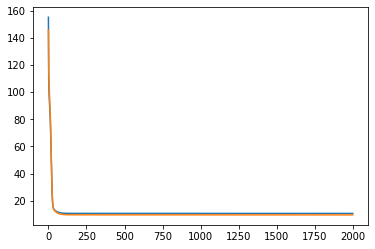

Test loss:  5.266


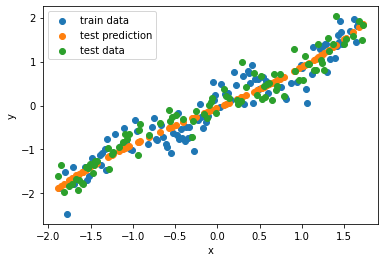

In [ ]:
x_train_right, y_train_right,  x_validation_right, y_validation_right, x_test_right, y_test_right = data_generator(noise=0.5, n_samples=300, D1=D1)
x_train_right = nparray_to_Var(x_train_right)
y_train_right = nparray_to_Var(y_train_right)
x_validation_right = nparray_to_Var(x_validation_right)
y_validation_right = nparray_to_Var(y_validation_right)
x_test_right = nparray_to_Var(x_test_right)
y_test_right = nparray_to_Var(y_test_right)

NN_right = [
    DenseLayer(1, 3, lambda x: x.exp()),
    DenseLayer(3, 1, lambda x: x.identity()),
]

fit_model(2000, 4e-4, NN_right, y_train_right, x_train_right, y_validation_right, x_validation_right, y_test_right, x_test_right)

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code